# Config


In [1]:
import base64, email, csv
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pickle, os
import pandas as pd
from bs4 import BeautifulSoup
import re
from IPython.display import clear_output
from datasets import Dataset
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np
import evaluate
from tqdm import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


/home/qq/my-jupyter-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)

## Google Scope

In [3]:
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

## Helper functions

In [8]:
def gmail_service():

    """
    Start gmail service, creating token.pickle file if needed
    Arguments:
    None
    Return:
    build('gmail', 'v1', credentials=creds) : Google credentials
    """
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as f:
            creds = pickle.load(f)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as f:
            pickle.dump(creds, f)
    return build('gmail', 'v1', credentials=creds)



def get_message_text(msg):
    """
    Gets text from message/mails
    Arguments:
    msg : message from fetching da
    Return:
    bbase64.urlsafe_b64decode(body.encode('ASCII')).decode('utf-8', errors='ignore') : decoded payload
    """
    if msg.get('payload') is None:
        return ''
    parts = msg['payload'].get('parts')
    if parts:
        for p in parts:
            if p.get('mimeType') == 'text/plain' and p.get('body', {}).get('data'):
                data = p['body']['data']
                return base64.urlsafe_b64decode(data.encode('ASCII')).decode('utf-8', errors='ignore')
    body = msg['payload'].get('body', {}).get('data')
    if body:
        return base64.urlsafe_b64decode(body.encode('ASCII')).decode('utf-8', errors='ignore')
    return ''


def fetch_and_save(max_messages=500, out_csv='gmail_emails.csv'):
    """
    fetch and save messages from Google API. Default max_messages is 500.
    Arguments:
    max_messages : number of maximum messages to fetch from Google API
    out_csv : name of the output file
    Return:
    csv file
    """
    service = gmail_service()
    results = service.users().messages().list(userId='me', maxResults=max_messages).execute()
    messages = results.get('messages', [])
    rows = []
    for m in messages:
        res = service.users().messages().get(userId='me', id=m['id'], format='full').execute()
        headers = {h['name']: h['value'] for h in res['payload'].get('headers', [])}
        subject = headers.get('Subject', '')
        sender = headers.get('From', '')
        date = headers.get('Date', '')
        labels = res.get('labelIds', [])
        text = get_message_text(res)
        rows.append({'id': m['id'], 'subject': subject, 'from': sender, 'date': date, 'labels': '|'.join(labels), 'text': text})
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"Saved {len(df)} messages to {out_csv}")

In [9]:
def clean_html(text):
    """
    Cleans HTML tags from text
    Arguments:
    text : input text to clean tags from
    Return:
    clean_text : cleaned text
    """
    if not isinstance(text, str):
        return text
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ', strip=True)
    clean_text = re.sub(r'(\\r\\n|\\r|\\n|\r|\n)', ' ', clean_text)
    invisible_chars = [
        '\u200B',
        '\u200C', 
        '\u200D',  
        '\uFEFF',  
        '\u034F',  
        '\u2060',  
        '\u180E',  
        '\u3164',  
        '\u2800',  
        '\u2028',  
        '\u2029',  
    ]
    for ch in invisible_chars:
        clean_text = clean_text.replace(ch, '')
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Getting mails from Gmail

In [6]:
fetch_and_save(out_csv = "100_mails.csv")

Saved 500 messages to 100_mails.csv


## Mails preprocessing

In [4]:
data = {
    
}

In [7]:
data["mails"] = pd.read_csv("gmail_emails.csv")

In [8]:
data["mails"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       500 non-null    object
 1   subject  498 non-null    object
 2   from     500 non-null    object
 3   date     500 non-null    object
 4   labels   500 non-null    object
 5   text     447 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB


In [9]:
data["mails"]["text"] = data["mails"]["text"].apply(clean_html)


In [10]:
#data["mails"]["text"].head(10)

In [11]:
data["mails"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       500 non-null    object
 1   subject  498 non-null    object
 2   from     500 non-null    object
 3   date     500 non-null    object
 4   labels   500 non-null    object
 5   text     447 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB


### Manual labelling

In [46]:
labels = ["Product Alerts / Price Deals", "Spam / Hazardous", "Shipping / Order Updates", "News / Informational Content", "Personal / Account Related", "Other"]
output_csv = "labeled_emails.csv"

In [47]:
# data["labeled"] = data["mails"]
# if "labels" not in data["labeled"].columns:
#     data["labeled"]["labels"] = None

In [48]:
# Doesn't work good in web browser

# for idx, row in data["labeled"].iterrows():
#     clear_output(wait=True) 
#     email_text = row["text"]

#     print("\n" + "="*50)
#     print(f"Email {idx+1}/{len(data['labeled'])}:")
#     print(email_text)
#     print("\nPossible labels:")
#     for i, label in enumerate(labels, 1):
#         print(f"{i}: {label}")

#     while True:
#         label_num = input("Enter label number: ").strip()
#         if label_num.isdigit() and 1 <= int(label_num) <= len(labels):
#             label = labels[int(label_num) - 1]
#             break
#         print(f"Invalid input! Please enter a number between 1 and {len(labels)}.")

#     data["labeled"].loc[idx, "labels"] = label
#     data["labeled"].to_csv(output_csv, index=False)

In [49]:
"""
labelled using external tools
"""

'\nlabelled using external tools\n'

In [50]:
data["mails"].to_csv("100-mails.csv")

# GPT - 2 based categorization

## Fine-tuning

In [17]:
data["labeled"] = pd.read_csv("labeled_dataset.csv")  # Must have 'text' and 'label' columns
data["labeled"] = data["labeled"][data["labeled"]["text"].notna()]
data["labeled"] = data["labeled"][["text","label"]]
data["dataset_labeled"] = Dataset.from_pandas(data["labeled"])

In [18]:
data["labeled"].label.value_counts()

label
Spam/Hazardous                  191
Product Alerts / Price Deals    187
News / Informational Content     32
Other                            16
Personal / Account Related       14
Name: count, dtype: int64

In [19]:
data["labeled"][data["labeled"]['label'] == "Personal / Account Related"]

,text,label
14,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 Transitional//EN""\r\n ""http://www.w3.org/TR/...",Personal / Account Related
17,\n\n Mubi.pl \n\n Najtańsze ubezpieczenie dla RENAULT Kol...,Personal / Account Related
91,========================================\r\nZobacz powiadomienia.\r\nhttps://www.facebook.com/nd...,Personal / Account Related
145,sie\r\n\r\n15\r\n\r\nPoinformuj klientów o godzinach otwarcia Twojej firmy w święta w sierpnia\r...,Personal / Account Related
166,\r\n \r\n \r\n\r\n This year’s in-demand computer science skills\r\n&zwnj; &zwnj; &zwnj; &zwnj;...,Personal / Account Related
222,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\nTwój raport dotyczący profilu firmy: 166 int...,Personal / Account Related
252,Opanuj analizę danych i zostań juniorem ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ...,Personal / Account Related
266,Wyliczenie składki dla Twojego samochodu:\r\nRENAULT Koleos z 2012 roku.\r\n\r\nDziękujemy za po...,Personal / Account Related
275,We'll downgrade you to our free plan today\r\n͏ ­͏ ­͏ ­͏ ­͏ ­͏ ­͏ ­͏ ­͏ ­͏ ­...,Personal / Account Related
306,========================================\r\nZobacz powiadomienia.\r\nhttps://www.facebook.com/nd...,Personal / Account Related


In [20]:
data["labeled"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 440 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    440 non-null    object
 1   label   440 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


In [21]:
data["dataset_labeled"] = data["dataset_labeled"].class_encode_column("label")

data["dataset_labeled"]  = data["dataset_labeled"].train_test_split(test_size=0.2)

Casting to class labels: 100%|██████| 440/440 [00:00<00:00, 37052.16 examples/s]


In [22]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = data["dataset_labeled"].map(tokenize, batched=True)

Map: 100%|███████████████████████████████| 88/88 [00:01<00:00, 85.19 examples/s]


In [23]:
num_labels = len(tokenized_dataset["train"].features["label"].names)

model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2", 
    num_labels=num_labels
)

model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./gpt2-email-classifier",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipykernel_6047/2022548250.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.690100
100,0.760100
150,0.651400
200,0.438100
250,0.313500


TrainOutput(global_step=264, training_loss=0.7475891221653331, metrics={'train_runtime': 70.7721, 'train_samples_per_second': 14.921, 'train_steps_per_second': 3.73, 'total_flos': 68984210718720.0, 'train_loss': 0.7475891221653331, 'epoch': 3.0})

In [25]:
data["labeled"].head(1)

,text,label
0,Znaleźliśmy okazję pasującą do Twojego alertu 'komputery i tablety'!\r\n\r\neSUN PLA Filamet do ...,Product Alerts / Price Deals


### Model manual test

In [86]:
raise Exception ("Break.")

Exception: Break.

In [ ]:
device = next(model.parameters()).device  # get model device (cpu or cuda)
test_email = "Znaleźliśmy okazję pasującą do Twojego alertu 'komputery i tablety'!"
inputs = tokenizer(test_email, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}  # move inputs to model device

outputs = model(**inputs)
predicted_label = outputs.logits.argmax(dim=-1).item()

label_names = tokenized_dataset["train"].features["label"].names
print("Predicted category:", label_names[predicted_label])

In [61]:
tokenized_dataset["train"].features["label"].names

['News / Informational Content',
 'Other',
 'Personal / Account Related',
 'Product Alerts / Price Deals',
 'Spam/Hazardous']

## Importing validation dataset 

In [5]:
data["validating"] = pd.read_csv("validation_dataset.csv")

In [6]:
data["validating"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  447 non-null    int64 
 1   id          447 non-null    object
 2   subject     447 non-null    object
 3   from        447 non-null    object
 4   date        447 non-null    object
 5   labels      447 non-null    object
 6   text        447 non-null    object
 7   label       447 non-null    object
dtypes: int64(1), object(7)
memory usage: 28.1+ KB


In [7]:
data["validating"] = data["validating"].drop(columns=["Unnamed: 0"])

In [8]:
data["validating"]["label"].value_counts()

label
Product Alerts / Price Deals    197
Spam/Hazardous                  192
News / Informational Content     32
Personal / Account Related       14
Other                            12
Name: count, dtype: int64

### 100 mails dataset

In [9]:
desired = {
    'Product Alerts / Price Deals': 27,
    'Spam/Hazardous': 27,
    'News / Informational Content': 20,
    'Personal / Account Related': 14,
    'Other': 12
}

In [10]:
parts = []
seed = 42
for label, n in desired.items():
    grp = data["validating"][data["validating"]['label'] == label]
    parts.append(grp.sample(n=n, random_state=seed))

In [11]:
data["validating_100mails"] = pd.concat(parts).sample(frac=1, random_state=seed).reset_index(drop=True)


In [12]:
data["validating_100mails"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       100 non-null    object
 1   subject  100 non-null    object
 2   from     100 non-null    object
 3   date     100 non-null    object
 4   labels   100 non-null    object
 5   text     100 non-null    object
 6   label    100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


In [13]:
data["validating_100mails"]["label"].value_counts()

label
Spam/Hazardous                  27
Product Alerts / Price Deals    27
News / Informational Content    20
Personal / Account Related      14
Other                           12
Name: count, dtype: int64

In [14]:
# import torch
# torch.cuda.empty_cache()

# GPT-2 Model based solution

In [26]:
device = next(model.parameters()).device

In [27]:

for idx, row in tqdm(data["validating_100mails"].iterrows(), total = len(data["validating_100mails"])):
    inputs = tokenizer(data["validating_100mails"].loc[idx, "text"], return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_label = outputs.logits.argmax(dim=-1).item()
    label_names = tokenized_dataset["train"].features["label"].names
    data["validating_100mails"].loc[idx,"label_GPT2FT"] = label_names[predicted_label]
    print("Predicted category:", label_names[predicted_label], data["validating_100mails"].loc[idx, "label"])


  6%|██▌                                        | 6/100 [00:00<00:03, 28.35it/s]

Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals


 15%|██████▎                                   | 15/100 [00:00<00:02, 37.36it/s]

Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals


 26%|██████████▉                               | 26/100 [00:00<00:01, 45.09it/s]

Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Other Other
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous News / Informational Content


 37%|███████████████▌                          | 37/100 [00:00<00:01, 45.33it/s]

Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous


 48%|████████████████████▏                     | 48/100 [00:01<00:01, 44.91it/s]

Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Other Other
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals


 59%|████████████████████████▊                 | 59/100 [00:01<00:00, 47.11it/s]

Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Personal / Account Related
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other


 65%|███████████████████████████▎              | 65/100 [00:01<00:00, 47.14it/s]

Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Other Other
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous News / Informational Content


 76%|███████████████████████████████▉          | 76/100 [00:01<00:00, 45.63it/s]

Predicted category: News / Informational Content News / Informational Content
Predicted category: Other Other
Predicted category: Product Alerts / Price Deals Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other


 87%|████████████████████████████████████▌     | 87/100 [00:01<00:00, 46.62it/s]

Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 45.10it/s]

Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Other Other
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Product Alerts / Price Deals Product Alerts / Price Deals
Predicted category: Other Other
Predicted category: Spam/Hazardous Spam/Hazardous


In [28]:
# from torch.utils.data import DataLoader

# def collate_fn(batch):
#     texts = [item["text"] for item in batch]
#     inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     return inputs

# dataloader = DataLoader(
#     data["validating_100mails"].to_dict("records"),
#     batch_size=1,  
#     collate_fn=collate_fn
# )

# label_names = tokenized_dataset["train"].features["label"].names
# predictions = []

# model.eval()
# with torch.no_grad():
#     for batch in dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         preds = outputs.logits.argmax(dim=-1).cpu().tolist()
#         predictions.extend(preds)

# data["validating_100mails"]["label_GPT2FT"] = [label_names[p] for p in predictions]

# Prompt based solution

## GPT-2

In [29]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [30]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [31]:
#data["validating_100mails"]["label_GPT2_Prompt"].value_counts()

In [32]:

for idx, row in tqdm(data["validating_100mails"].iterrows(), total = len(data["validating_100mails"])):
    email_text = data["validating_100mails"].loc[idx, "text"]
    prompt = f"""Email: "{email_text}"
Classify this email into one or more of the following categories, and provide a confidence score for each:
- Spam/Hazardous
- Product Alerts/Price Deals
- News/Informational Content
- Personal/Account Related
- Other
Answer with the category/categories and their confidence scores:"""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=min(1024, inputs['input_ids'].shape[1] + 10))
    outputs = model.generate(**inputs, max_new_tokens=10, do_sample=False)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = generated_text.split("Answer:")[-1].strip()
    data["validating_100mails"].loc[idx, "label_GPT2_Prompt"] = answer

100%|█████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


In [33]:
data["validating_100mails"]["label_GPT2_Prompt"] = "Other"

## XLM-Roberta_Large

In [50]:
classifier = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli",
    device=-1 
)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [51]:
candidate_labels = [
    "Spam/Hazardous",
    "Product Alerts / Price Deals",
    "News / Informational Content",
    "Personal / Account Related",
    "Other"
]

In [52]:
for idx, row in tqdm(data["validating_100mails"].iterrows(), total = len(data["validating_100mails"])):
    text = data["validating_100mails"].loc[idx, "text"]
    result = classifier(text, candidate_labels=candidate_labels)
    data["validating_100mails"].loc[idx, "label_XLM_Roberta_Base_Prompt"] = result['labels'][0]
    print("Predicted category:", result['labels'][0], "| Scores:", result['scores'][0], "Labeled:", data["validating_100mails"].loc[idx, "label"])


  1%|▍                                          | 1/100 [00:06<11:28,  6.95s/it]

Predicted category: Other | Scores: 0.21428439021110535 Labeled: Personal / Account Related


  2%|▊                                          | 2/100 [00:10<07:51,  4.81s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.2806500494480133 Labeled: Spam/Hazardous


  3%|█▎                                         | 3/100 [00:17<09:12,  5.69s/it]

Predicted category: News / Informational Content | Scores: 0.24458542466163635 Labeled: News / Informational Content


  4%|█▋                                         | 4/100 [00:23<09:54,  6.19s/it]

Predicted category: Other | Scores: 0.23897777497768402 Labeled: Spam/Hazardous


  5%|██▏                                        | 5/100 [00:29<09:29,  6.00s/it]

Predicted category: News / Informational Content | Scores: 0.25784626603126526 Labeled: Spam/Hazardous


  6%|██▌                                        | 6/100 [00:31<07:10,  4.58s/it]

Predicted category: Other | Scores: 0.5191241502761841 Labeled: Spam/Hazardous


  7%|███                                        | 7/100 [00:35<06:52,  4.43s/it]

Predicted category: Other | Scores: 0.27066493034362793 Labeled: Product Alerts / Price Deals


  8%|███▍                                       | 8/100 [00:39<06:33,  4.27s/it]

Predicted category: Other | Scores: 0.2071346789598465 Labeled: Personal / Account Related


  9%|███▊                                       | 9/100 [00:43<06:12,  4.09s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.3434215188026428 Labeled: Product Alerts / Price Deals


 10%|████▏                                     | 10/100 [00:46<05:54,  3.94s/it]

Predicted category: Other | Scores: 0.38457027077674866 Labeled: Product Alerts / Price Deals


 11%|████▌                                     | 11/100 [00:50<05:39,  3.82s/it]

Predicted category: Other | Scores: 0.4134226143360138 Labeled: Product Alerts / Price Deals


 12%|█████                                     | 12/100 [00:57<07:00,  4.78s/it]

Predicted category: Other | Scores: 0.29273858666419983 Labeled: Spam/Hazardous


 13%|█████▍                                    | 13/100 [01:00<06:14,  4.31s/it]

Predicted category: Other | Scores: 0.506210446357727 Labeled: News / Informational Content


 14%|█████▉                                    | 14/100 [01:07<07:19,  5.11s/it]

Predicted category: Personal / Account Related | Scores: 0.21911484003067017 Labeled: Spam/Hazardous


 15%|██████▎                                   | 15/100 [01:08<05:33,  3.92s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 16%|██████▋                                   | 16/100 [01:12<05:27,  3.90s/it]

Predicted category: Other | Scores: 0.3920935094356537 Labeled: Product Alerts / Price Deals


 17%|███████▏                                  | 17/100 [01:18<06:21,  4.60s/it]

Predicted category: Other | Scores: 0.21397700905799866 Labeled: Personal / Account Related


 18%|███████▌                                  | 18/100 [01:23<06:17,  4.61s/it]

Predicted category: Personal / Account Related | Scores: 0.21648532152175903 Labeled: Personal / Account Related


 19%|███████▉                                  | 19/100 [01:27<05:53,  4.36s/it]

Predicted category: Other | Scores: 0.3562549948692322 Labeled: Product Alerts / Price Deals


 20%|████████▍                                 | 20/100 [01:34<06:59,  5.24s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.2133440524339676 Labeled: Spam/Hazardous


 21%|████████▊                                 | 21/100 [01:41<07:42,  5.86s/it]

Predicted category: News / Informational Content | Scores: 0.22996455430984497 Labeled: News / Informational Content


 22%|█████████▏                                | 22/100 [01:42<05:48,  4.47s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 23%|█████████▋                                | 23/100 [01:46<05:33,  4.33s/it]

Predicted category: Other | Scores: 0.3467523157596588 Labeled: Product Alerts / Price Deals


 24%|██████████                                | 24/100 [01:55<06:58,  5.51s/it]

Predicted category: News / Informational Content | Scores: 0.21253982186317444 Labeled: Spam/Hazardous


 25%|██████████▌                               | 25/100 [02:02<07:24,  5.93s/it]

Predicted category: Personal / Account Related | Scores: 0.20665575563907623 Labeled: News / Informational Content


 26%|██████████▉                               | 26/100 [02:06<06:41,  5.43s/it]

Predicted category: Other | Scores: 0.2605690360069275 Labeled: Product Alerts / Price Deals


 27%|███████████▎                              | 27/100 [02:13<07:08,  5.87s/it]

Predicted category: Other | Scores: 0.2164989560842514 Labeled: Spam/Hazardous


 28%|███████████▊                              | 28/100 [02:14<05:19,  4.44s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 29%|████████████▏                             | 29/100 [02:18<04:58,  4.21s/it]

Predicted category: Other | Scores: 0.3452088534832001 Labeled: Product Alerts / Price Deals


 30%|████████████▌                             | 30/100 [02:25<05:56,  5.09s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.20435236394405365 Labeled: News / Informational Content


 31%|█████████████                             | 31/100 [02:29<05:25,  4.72s/it]

Predicted category: Other | Scores: 0.3747301697731018 Labeled: Product Alerts / Price Deals


 32%|█████████████▍                            | 32/100 [02:36<06:18,  5.57s/it]

Predicted category: Other | Scores: 0.2404625564813614 Labeled: Spam/Hazardous


 33%|█████████████▊                            | 33/100 [02:42<06:24,  5.74s/it]

Predicted category: Spam/Hazardous | Scores: 0.22045916318893433 Labeled: Personal / Account Related


 34%|██████████████▎                           | 34/100 [02:50<06:51,  6.24s/it]

Predicted category: Other | Scores: 0.3225920796394348 Labeled: Spam/Hazardous


 35%|██████████████▋                           | 35/100 [02:51<05:08,  4.74s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 36%|███████████████                           | 36/100 [02:55<04:42,  4.41s/it]

Predicted category: Other | Scores: 0.3965597450733185 Labeled: Product Alerts / Price Deals


 37%|███████████████▌                          | 37/100 [02:58<04:22,  4.17s/it]

Predicted category: Other | Scores: 0.21500307321548462 Labeled: News / Informational Content


 38%|███████████████▉                          | 38/100 [03:05<05:12,  5.05s/it]

Predicted category: Other | Scores: 0.20474590361118317 Labeled: News / Informational Content


 39%|████████████████▍                         | 39/100 [03:12<05:46,  5.68s/it]

Predicted category: Other | Scores: 0.23212271928787231 Labeled: Spam/Hazardous


 40%|████████████████▊                         | 40/100 [03:17<05:16,  5.27s/it]

Predicted category: Other | Scores: 0.33373725414276123 Labeled: Product Alerts / Price Deals


 41%|█████████████████▏                        | 41/100 [03:24<05:40,  5.77s/it]

Predicted category: Other | Scores: 0.3215219974517822 Labeled: Spam/Hazardous


 42%|█████████████████▋                        | 42/100 [03:31<05:53,  6.10s/it]

Predicted category: Other | Scores: 0.47840026021003723 Labeled: Spam/Hazardous


 43%|██████████████████                        | 43/100 [03:34<05:03,  5.32s/it]

Predicted category: Other | Scores: 0.35243791341781616 Labeled: Product Alerts / Price Deals


 44%|██████████████████▍                       | 44/100 [03:35<03:47,  4.06s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 45%|██████████████████▉                       | 45/100 [03:42<04:33,  4.98s/it]

Predicted category: Personal / Account Related | Scores: 0.23318569362163544 Labeled: Spam/Hazardous


 46%|███████████████████▎                      | 46/100 [03:46<04:09,  4.61s/it]

Predicted category: Other | Scores: 0.41799497604370117 Labeled: Product Alerts / Price Deals


 47%|███████████████████▋                      | 47/100 [03:53<04:38,  5.26s/it]

Predicted category: Other | Scores: 0.2614644765853882 Labeled: Personal / Account Related


 48%|████████████████████▏                     | 48/100 [03:56<04:08,  4.77s/it]

Predicted category: Other | Scores: 0.38637804985046387 Labeled: Product Alerts / Price Deals


 49%|████████████████████▌                     | 49/100 [04:03<04:34,  5.39s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.21335303783416748 Labeled: News / Informational Content


 50%|█████████████████████                     | 50/100 [04:07<04:02,  4.85s/it]

Predicted category: Other | Scores: 0.3153698444366455 Labeled: Product Alerts / Price Deals


 51%|█████████████████████▍                    | 51/100 [04:10<03:37,  4.45s/it]

Predicted category: Other | Scores: 0.42083773016929626 Labeled: Product Alerts / Price Deals


 52%|█████████████████████▊                    | 52/100 [04:14<03:23,  4.24s/it]

Predicted category: Other | Scores: 0.4488176107406616 Labeled: Product Alerts / Price Deals


 53%|██████████████████████▎                   | 53/100 [04:18<03:13,  4.12s/it]

Predicted category: Other | Scores: 0.40015217661857605 Labeled: Product Alerts / Price Deals


 54%|██████████████████████▋                   | 54/100 [04:19<02:28,  3.22s/it]

Predicted category: Other | Scores: 0.6559736728668213 Labeled: Spam/Hazardous


 55%|███████████████████████                   | 55/100 [04:23<02:31,  3.38s/it]

Predicted category: Other | Scores: 0.3965049088001251 Labeled: Product Alerts / Price Deals


 56%|███████████████████████▌                  | 56/100 [04:25<02:06,  2.88s/it]

Predicted category: Other | Scores: 0.4468523859977722 Labeled: Personal / Account Related


 57%|███████████████████████▉                  | 57/100 [04:28<02:11,  3.06s/it]

Predicted category: Other | Scores: 0.3987542986869812 Labeled: Product Alerts / Price Deals


 58%|████████████████████████▎                 | 58/100 [04:35<02:55,  4.18s/it]

Predicted category: Other | Scores: 0.21865054965019226 Labeled: News / Informational Content


 59%|████████████████████████▊                 | 59/100 [04:42<03:23,  4.96s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.21230752766132355 Labeled: Spam/Hazardous


 60%|█████████████████████████▏                | 60/100 [04:43<02:32,  3.81s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 61%|█████████████████████████▌                | 61/100 [04:50<03:04,  4.72s/it]

Predicted category: News / Informational Content | Scores: 0.20450255274772644 Labeled: News / Informational Content


 62%|██████████████████████████                | 62/100 [04:51<02:18,  3.64s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 63%|██████████████████████████▍               | 63/100 [04:58<02:51,  4.63s/it]

Predicted category: Other | Scores: 0.2717469334602356 Labeled: News / Informational Content


 64%|██████████████████████████▉               | 64/100 [05:04<03:10,  5.30s/it]

Predicted category: Other | Scores: 0.2902959883213043 Labeled: Spam/Hazardous


 65%|███████████████████████████▎              | 65/100 [05:11<03:21,  5.77s/it]

Predicted category: Other | Scores: 0.24530303478240967 Labeled: Spam/Hazardous


 66%|███████████████████████████▋              | 66/100 [05:18<03:27,  6.09s/it]

Predicted category: News / Informational Content | Scores: 0.2028537392616272 Labeled: News / Informational Content


 67%|████████████████████████████▏             | 67/100 [05:25<03:29,  6.35s/it]

Predicted category: Other | Scores: 0.2287803441286087 Labeled: Spam/Hazardous


 68%|████████████████████████████▌             | 68/100 [05:32<03:30,  6.59s/it]

Predicted category: Other | Scores: 0.2273266762495041 Labeled: News / Informational Content


 69%|████████████████████████████▉             | 69/100 [05:42<03:52,  7.49s/it]

Predicted category: Personal / Account Related | Scores: 0.21923646330833435 Labeled: News / Informational Content


 70%|█████████████████████████████▍            | 70/100 [05:43<02:48,  5.62s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 71%|█████████████████████████████▊            | 71/100 [05:51<03:00,  6.22s/it]

Predicted category: Personal / Account Related | Scores: 0.20880712568759918 Labeled: Personal / Account Related


 72%|██████████████████████████████▏           | 72/100 [05:58<03:01,  6.49s/it]

Predicted category: Other | Scores: 0.22730354964733124 Labeled: Spam/Hazardous


 73%|██████████████████████████████▋           | 73/100 [06:05<03:00,  6.69s/it]

Predicted category: Other | Scores: 0.2350521683692932 Labeled: News / Informational Content


 74%|███████████████████████████████           | 74/100 [06:07<02:16,  5.24s/it]

Predicted category: Other | Scores: 0.42749837040901184 Labeled: Spam/Hazardous


 75%|███████████████████████████████▌          | 75/100 [06:08<01:39,  3.99s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 76%|███████████████████████████████▉          | 76/100 [06:15<01:58,  4.92s/it]

Predicted category: Other | Scores: 0.21402952075004578 Labeled: News / Informational Content


 77%|████████████████████████████████▎         | 77/100 [06:18<01:37,  4.22s/it]

Predicted category: Other | Scores: 0.3105887770652771 Labeled: Personal / Account Related


 78%|████████████████████████████████▊         | 78/100 [06:25<01:51,  5.07s/it]

Predicted category: Other | Scores: 0.28348442912101746 Labeled: Spam/Hazardous


 79%|█████████████████████████████████▏        | 79/100 [06:26<01:21,  3.88s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 80%|█████████████████████████████████▌        | 80/100 [06:33<01:35,  4.80s/it]

Predicted category: Other | Scores: 0.245676651597023 Labeled: News / Informational Content


 81%|██████████████████████████████████        | 81/100 [06:35<01:15,  3.96s/it]

Predicted category: Other | Scores: 0.4239031672477722 Labeled: News / Informational Content


 82%|██████████████████████████████████▍       | 82/100 [06:40<01:20,  4.48s/it]

Predicted category: News / Informational Content | Scores: 0.21358352899551392 Labeled: Personal / Account Related


 83%|██████████████████████████████████▊       | 83/100 [06:45<01:15,  4.42s/it]

Predicted category: Product Alerts / Price Deals | Scores: 0.20765922963619232 Labeled: Spam/Hazardous


 84%|███████████████████████████████████▎      | 84/100 [06:52<01:23,  5.20s/it]

Predicted category: Other | Scores: 0.21913592517375946 Labeled: Spam/Hazardous


 85%|███████████████████████████████████▋      | 85/100 [06:56<01:13,  4.93s/it]

Predicted category: Other | Scores: 0.21215611696243286 Labeled: Product Alerts / Price Deals


 86%|████████████████████████████████████      | 86/100 [06:59<01:01,  4.43s/it]

Predicted category: Other | Scores: 0.23350393772125244 Labeled: Spam/Hazardous


 87%|████████████████████████████████████▌     | 87/100 [07:04<00:58,  4.49s/it]

Predicted category: Other | Scores: 0.24946601688861847 Labeled: Product Alerts / Price Deals


 88%|████████████████████████████████████▉     | 88/100 [07:07<00:50,  4.19s/it]

Predicted category: Other | Scores: 0.4591869115829468 Labeled: Product Alerts / Price Deals


 89%|█████████████████████████████████████▍    | 89/100 [07:11<00:43,  3.93s/it]

Predicted category: Other | Scores: 0.38828882575035095 Labeled: Product Alerts / Price Deals


 90%|█████████████████████████████████████▊    | 90/100 [07:17<00:47,  4.72s/it]

Predicted category: Personal / Account Related | Scores: 0.21397100389003754 Labeled: Personal / Account Related


 91%|██████████████████████████████████████▏   | 91/100 [07:18<00:32,  3.63s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


 92%|██████████████████████████████████████▋   | 92/100 [07:24<00:33,  4.15s/it]

Predicted category: Other | Scores: 0.20864900946617126 Labeled: Personal / Account Related


 93%|███████████████████████████████████████   | 93/100 [07:27<00:27,  3.98s/it]

Predicted category: Other | Scores: 0.2905011475086212 Labeled: Personal / Account Related


 94%|███████████████████████████████████████▍  | 94/100 [07:31<00:23,  3.97s/it]

Predicted category: Other | Scores: 0.20321375131607056 Labeled: Personal / Account Related


 95%|███████████████████████████████████████▉  | 95/100 [07:35<00:19,  3.86s/it]

Predicted category: Other | Scores: 0.3654470443725586 Labeled: Product Alerts / Price Deals


 96%|████████████████████████████████████████▎ | 96/100 [07:42<00:19,  4.81s/it]

Predicted category: Spam/Hazardous | Scores: 0.2279188334941864 Labeled: News / Informational Content


 97%|████████████████████████████████████████▋ | 97/100 [07:49<00:16,  5.42s/it]

Predicted category: Other | Scores: 0.2685990035533905 Labeled: News / Informational Content


 98%|█████████████████████████████████████████▏| 98/100 [07:52<00:09,  4.84s/it]

Predicted category: Other | Scores: 0.4439656734466553 Labeled: Product Alerts / Price Deals


 99%|█████████████████████████████████████████▌| 99/100 [07:53<00:03,  3.72s/it]

Predicted category: Other | Scores: 0.7563576698303223 Labeled: Other


100%|█████████████████████████████████████████| 100/100 [08:00<00:00,  4.81s/it]

Predicted category: Other | Scores: 0.22176674008369446 Labeled: Spam/Hazardous


# Few shot prompting

## paraphrase-multilingual-MiniLM-L12-v2

In [53]:
examples = {
    "Spam/Hazardous": [
        "Twój alert o ofertach pracy na stanowisko Elektryk w lokalizacji Polska",
        "Wybierz swój ulubiony produkt!",
        "Letnie wypady last minute z: Warszawa",
        "Złap je, zanim lato się skończy – tylko na vitay.pl!",
        "We'll downgrade you to our free plan today"
    ],
    "Product Alerts / Price Deals": [
        "Znaleźliśmy okazję pasującą do Twojego alertu ",
        "w cenie podstawowych! Codziennie, w godz. 14:00-18:00. Nie przegap okazji i sprawdź szczegóły! "
    ],
    "News / Informational Content": [
        "Desktop Mobile Design Gr, your Thangs fans love what you're creating! Your Creator Analytics Creator Rank Top 15%",
        "Język Ladder na tle innych języków dla PLC Cześć",
        "Trending Stories from Amader Electronics -----",
        "Webinar dzisiaj 20:00 - widzimy się! Cześć",
        "( https://realpython.com/ ) Hi Gr, We’ve missed seeing you around! "
        
    ],
    "Personal / Account Related": [
        "Nowa transakcja płatnicza Szczegóły Rozpoczęliśmy proces płatności",
        "Twój raport dotyczący profilu firmy: 166 interakcji* z zeszłego miesiąca Zobacz wyniki firmy ",
        "Wyliczenie składki dla Twojego samochodu: ",
        "Dzień dobry! Miło nam poinformować, że otrzymaliśmy Twoją wpłatę i zabieramy się do realizacji zamówienia:"
        
    ],
    "Other": [
        "Plain text version not available"]}

In [54]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [55]:


example_texts = []
example_labels = []

for label, texts in examples.items():
    example_texts.extend(texts)
    example_labels.extend([label]*len(texts))

example_embeddings = model.encode(example_texts, convert_to_tensor=True)

In [56]:
for idx, row in tqdm(data["validating_100mails"].iterrows(), total = len(data["validating_100mails"])):
    email_to_classify = data["validating_100mails"].loc[idx, "text"]
    email_embedding = model.encode(email_to_classify, convert_to_tensor=True)
    cos_scores = util.cos_sim(email_embedding, example_embeddings)
    best_idx = torch.argmax(cos_scores)
    predicted_label = example_labels[best_idx]
    data["validating_100mails"].loc[idx, "MiniLM_few_shot_prompting"] = predicted_label
    print("Predicted category:", predicted_label, data["validating_100mails"].loc[idx, "label"])


 14%|█████▉                                    | 14/100 [00:00<00:01, 70.93it/s]

Predicted category: Personal / Account Related Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Personal / Account Related Spam/Hazardous
Predicted category: Product Alerts / Price Deals Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Personal / Account Related Product Alerts / Price Deals
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: Other Other
Predicted category: News /

 33%|█████████████▊                            | 33/100 [00:00<00:00, 83.30it/s]

Predicted category: News / Informational Content Personal / Account Related
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Other Other
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: Personal / Account Related Product Alerts / Price Deals
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Spam

 53%|██████████████████████▎                   | 53/100 [00:00<00:00, 89.20it/s]

Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Spam/Hazardous News / Informational Content
Predicted category: Personal / Account Related Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Other Other
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content Product A

 71%|█████████████████████████████▊            | 71/100 [00:00<00:00, 84.56it/s]

Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: Other Other
Predicted category: News / Informational Content News / Informational Content
Predicted category: Other Other
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content News / Informational Content
Predicted 

 90%|█████████████████████████████████████▊    | 90/100 [00:01<00:00, 86.46it/s]

Predicted category: News / Informational Content News / Informational Content
Predicted category: Personal / Account Related Spam/Hazardous
Predicted category: Other Other
Predicted category: News / Informational Content News / Informational Content
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: Other Other
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content News / Informational Content
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Spam/Hazardous Spam/Hazardous
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Con

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 84.31it/s]

Predicted category: Other Other
Predicted category: Spam/Hazardous Personal / Account Related
Predicted category: Product Alerts / Price Deals Personal / Account Related
Predicted category: Personal / Account Related Personal / Account Related
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content News / Informational Content
Predicted category: News / Informational Content Product Alerts / Price Deals
Predicted category: Other Other
Predicted category: Personal / Account Related Spam/Hazardous


# Stats / Graphical representation of data 

In [58]:
data["validating_100mails"].to_csv("2025-09-02_results.csv")

In [59]:
data["validating_100mails"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id                             100 non-null    object
 1   subject                        100 non-null    object
 2   from                           100 non-null    object
 3   date                           100 non-null    object
 4   labels                         100 non-null    object
 5   text                           100 non-null    object
 6   label                          100 non-null    object
 7   label_GPT2FT                   100 non-null    object
 8   label_GPT2_Prompt              100 non-null    object
 9   label_XLM_Roberta_Base_Prompt  100 non-null    object
 10  MiniLM_few_shot_prompting      100 non-null    object
dtypes: object(11)
memory usage: 8.7+ KB


In [60]:
columns_to_plot = [
    "label", 
    "label_XLM_Roberta_Base_Prompt",
    "label_GPT2_Prompt",
    "MiniLM_few_shot_prompting",
    "label_GPT2FT"
]

df = data["validating_100mails"][columns_to_plot]

## Count of labels

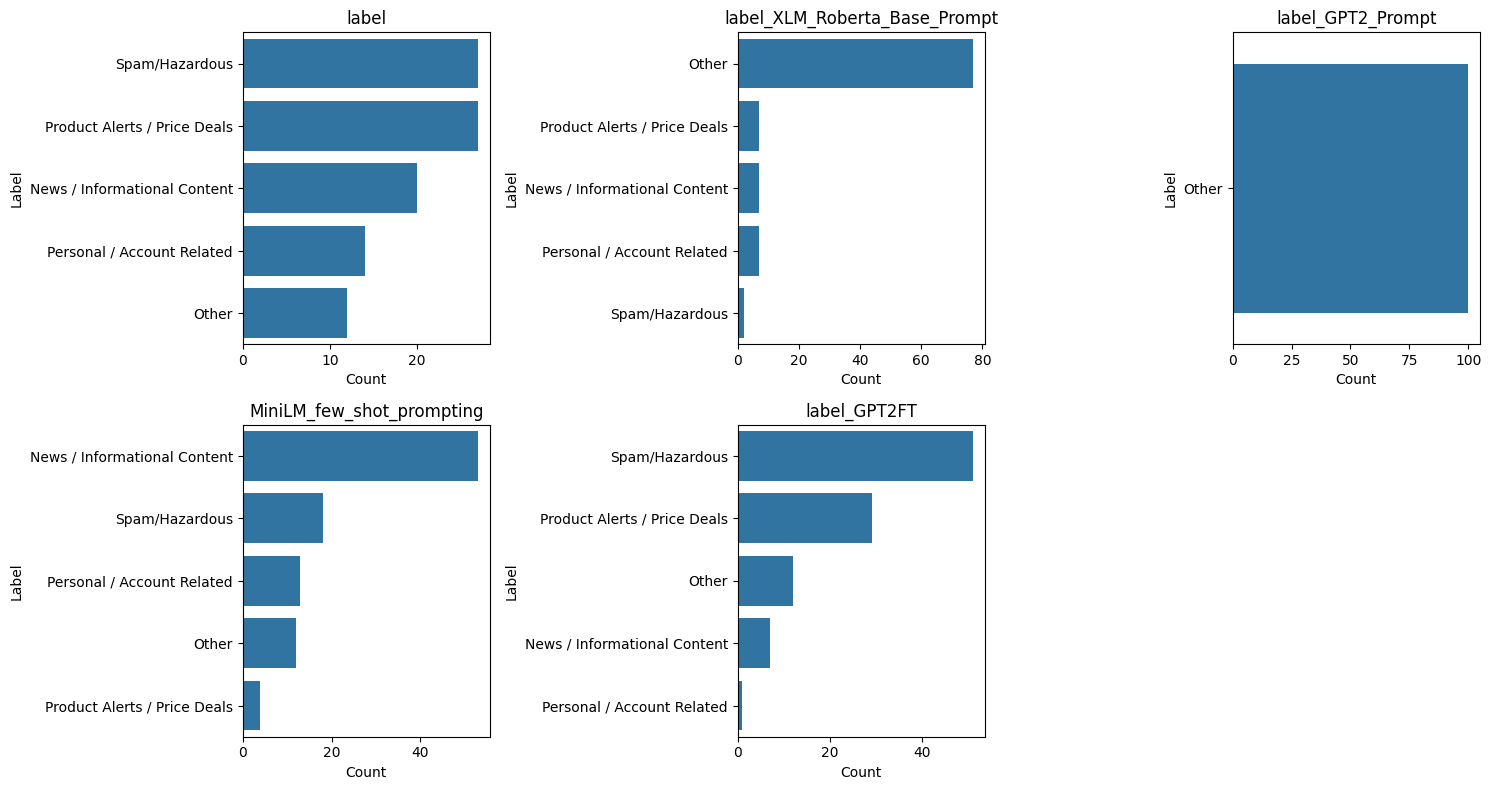

In [61]:
plt.figure(figsize=(15,8))

for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(col)
    plt.xlabel("Count")
    plt.ylabel("Label")

plt.tight_layout()
plt.show()

## Model Predictions vs Original labels

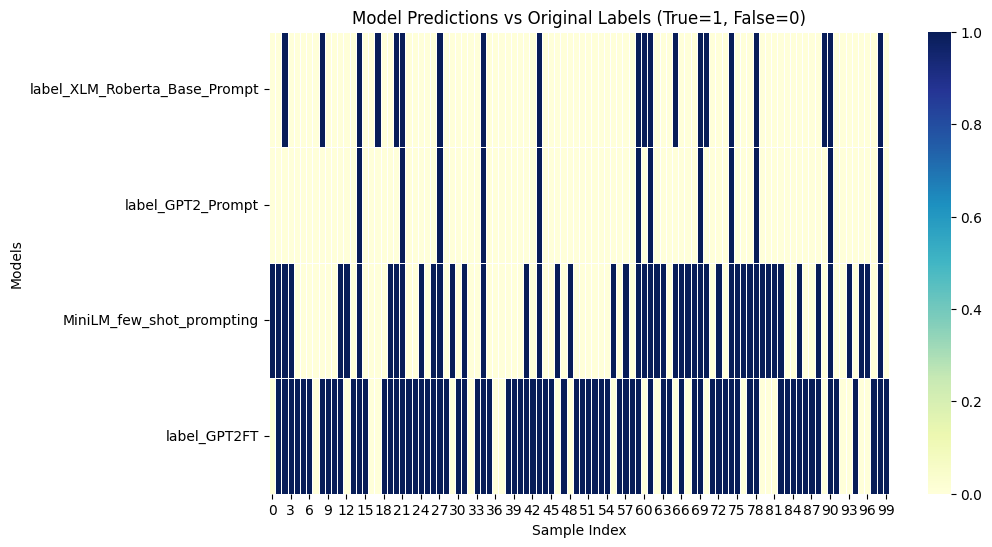

In [62]:
accuracy_df = pd.DataFrame()

for col in columns_to_plot[1:]:
    accuracy_df[col] = df[col] == df["label"]

plt.figure(figsize=(10,6))
sns.heatmap(accuracy_df.T, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Model Predictions vs Original Labels (True=1, False=0)")
plt.xlabel("Sample Index")
plt.ylabel("Models")
plt.show()


## Confusion matrix

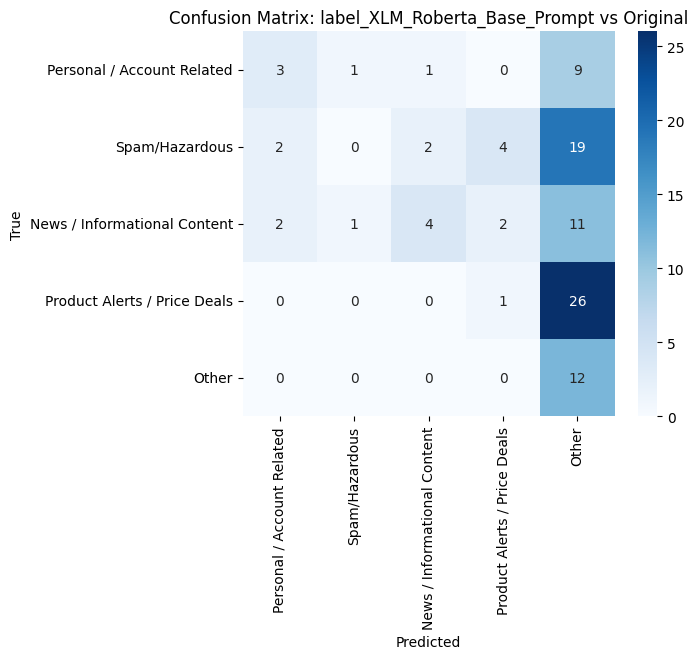

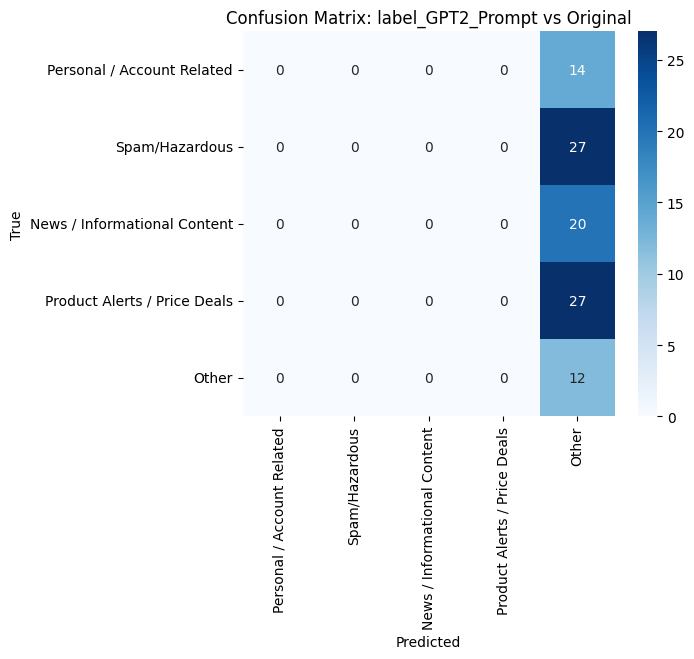

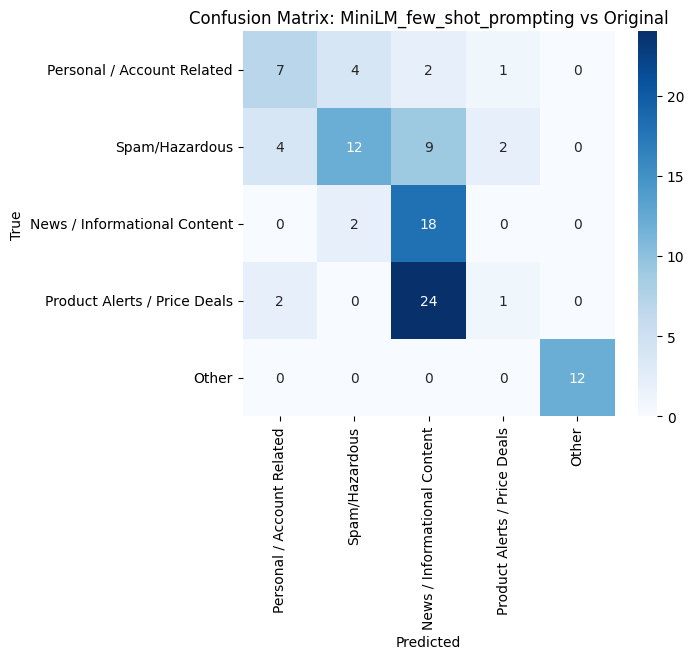

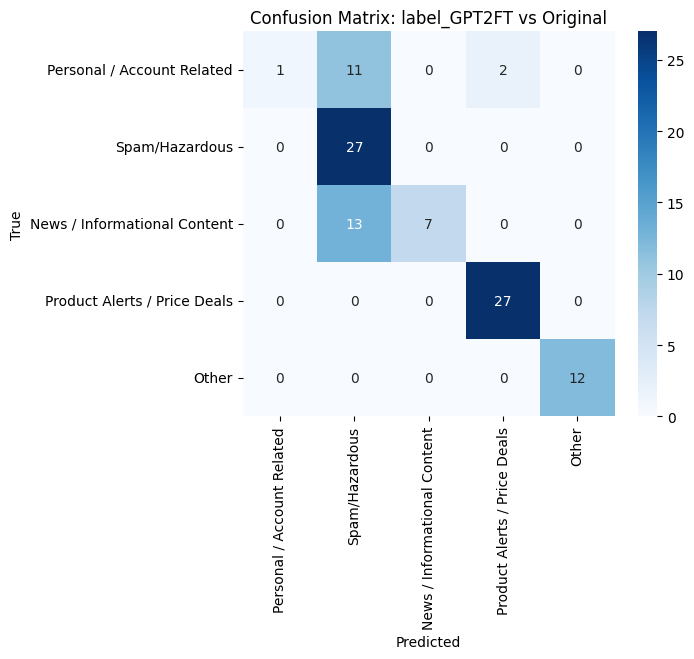

In [63]:
for col in columns_to_plot[1:]:
    cm = confusion_matrix(df["label"], df[col], labels=df["label"].unique())
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=df["label"].unique(), yticklabels=df["label"].unique(), cmap="Blues")
    plt.title(f"Confusion Matrix: {col} vs Original")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## Percentage of correct answers

In [69]:
model_columns = [
    "label_XLM_Roberta_Base_Prompt",
    "label_GPT2_Prompt",
    "MiniLM_few_shot_prompting",
    "label_GPT2FT"
]

In [70]:
accuracy = {
    col: (data["validating_100mails"][col] == data["validating_100mails"]["label"]).mean() * 100
    for col in model_columns
}


In [71]:
accuracy_df = pd.DataFrame(list(accuracy.items()), columns=["Model", "Accuracy (%)"])

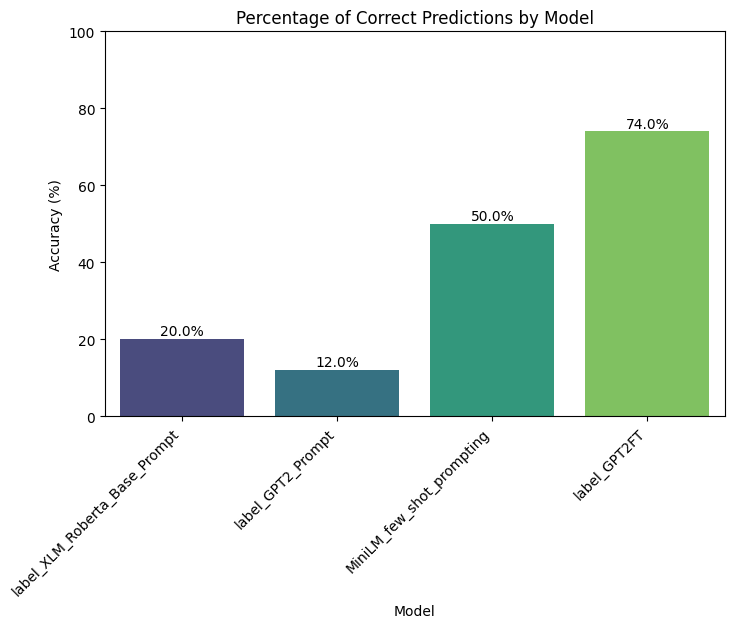

In [73]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy (%)", data=accuracy_df,hue = "Model" ,palette="viridis")
plt.ylim(0, 100)
plt.title("Percentage of Correct Predictions by Model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")

for index, row in accuracy_df.iterrows():
    plt.text(index, row["Accuracy (%)"] + 1, f"{row['Accuracy (%)']:.1f}%", ha='center')

plt.show()